Project 2.

In [125]:
# import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


In [126]:
# Loading the dataset
data = pd.read_csv('/content/project_2_data.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [127]:
# Check for missing values
print("Missing values:",data.isnull().sum().sum())
# Check for duplicated values
print("Duplicated values:",data.duplicated().sum().sum())

Missing values: 7829
Duplicated values: 0


In [128]:
#Filling mising values with median for numeric and mode for objects
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
    elif data[column].dtype == 'int64' or data[column].dtype == 'float64':
        data[column].fillna(data[column].median(), inplace=True)


In [129]:
# After filling the na values re-check for missing
print("Missing values:",data.isnull().sum().sum())
print("Duplicated values:",data.duplicated().sum().sum())

Missing values: 0
Duplicated values: 0


In [130]:
# Check for columns with low variance or high percentage of unique values
for column in data.columns:
  if data[column].dtype == 'object':
    continue
  if data[column].nunique() / len(data) > 0.95:
    print(f"Column '{column}' has a high percentage of unique values and might be useless.")
  elif data[column].var() < 0.1: # Adjust the threshold as needed
    print(f"Column '{column}' has low variance and might be useless.")

# Check for columns with a single unique value
for column in data.columns:
  if data[column].nunique() == 1:
    print(f"Column '{column}' has only one unique value and can be deleted.")


Column 'Id' has a high percentage of unique values and might be useless.
Column 'BsmtHalfBath' has low variance and might be useless.
Column 'KitchenAbvGr' has low variance and might be useless.


In [131]:
for column in data.select_dtypes(include=['int64', 'float64']).columns:
    # Calculate the IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median
    data[column] = np.where(data[column] < lower_bound, data[column].median(), data[column])
    data[column] = np.where(data[column] > upper_bound, data[column].median(), data[column])


In [132]:
# H0 -> there is no statistically significant difference in the average SalePrice among different GarageFinish categories.
# H1 -> There is a statistically significant difference in the average SalePrice among different GarageFinish categories.
# h0 being the Null Hypothesis, and h1 being Alternative Hypothesis
# Choice of test: one-way ANOVA test
# why? We have one independent variable (GarageFinish) with multiple categories.

In [133]:
#import libraries=
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [134]:
# Perform ANOVA
model = ols('SalePrice ~ C(GarageFinish)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print('===============================================================')
# Perform post-hoc analysis (Tukey's HSD)
# seperates garageFinish into groups
m_comp = pairwise_tukeyhsd(data['SalePrice'], data['GarageFinish'], alpha=0.05)
print(m_comp)

                       sum_sq      df           F         PR(>F)
C(GarageFinish)  1.471012e+12     2.0  311.835941  1.857643e-113
Residual         3.436525e+12  1457.0         NaN            NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------
   Fin    RFn -11527.8813 0.003  -19752.579  -3303.1836   True
   Fin    Unf -69330.7214   0.0 -76801.0948 -61860.3481   True
   RFn    Unf -57802.8401   0.0 -64851.8581 -50753.8221   True
--------------------------------------------------------------


In [135]:
# After conducting the following analysis, the conclusion is:
# we have 3 adjusted p-values, and since alpha is 0.05
# 0.4546: This p-value is greater than 0.05
# 0.0: These p-values are less than 0.05
# Since we have some p-values less than 0.05, we reject the hypothesis meaning that
# theres an overall significant difference among the data
# conclusion: we reject h0

In [136]:
# To conduct a multiple linear regression model we first need to find the best predictorfrom sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Separate features (X) and target variable (y)
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']
# Select numerical features for Lasso regression
X_num = X.select_dtypes(include=['int64', 'float64'])
# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)
# Combine numerical and encoded features
X = pd.concat([X_num, X_encoded], axis=1)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create and fit LassoCV model (cross-validated Lasso)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
# Get the best alpha (regularization strength)
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")
# Get coefficients (feature importances)
coefficients = lasso_cv.coef_
# Find the best predictors
selected_features = []
for i, feature in enumerate(X.columns):
    if coefficients[i] != 0:
        selected_features.append(feature)



Best alpha: 794.1287702808332


In [137]:
# Updating the data set with all the features needed
for column in data.columns:
  if column not in selected_features:
    data.drop(column, axis=1, inplace=True)
data['SalePrice'] = y

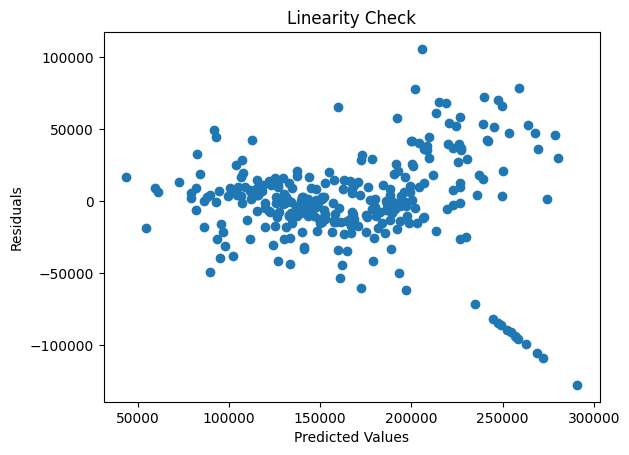

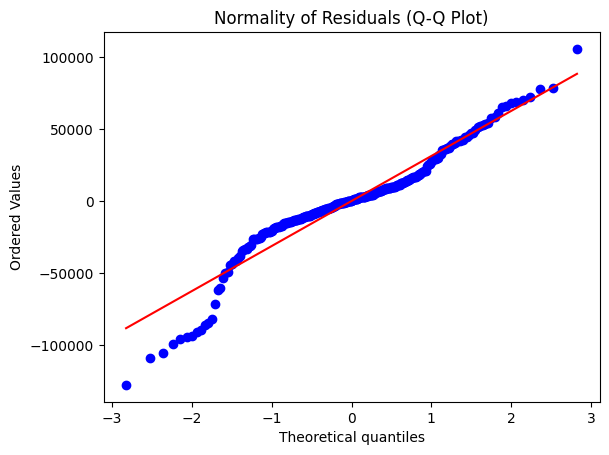

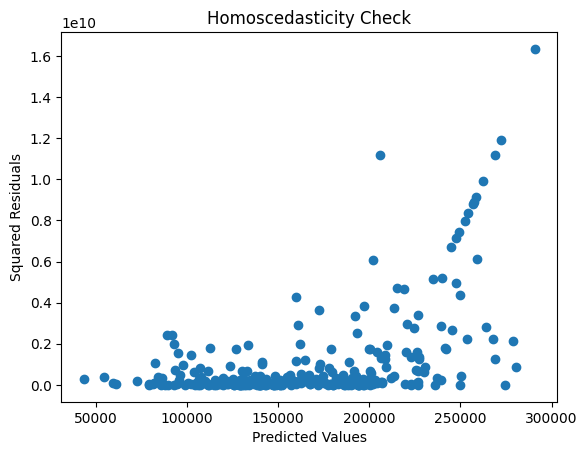

VIF: [5.268027012717733, 35.48645186739127, 15.246470465629445, 44.73783994938324, 57.952068254675034, 9194.162952900562, 9380.76623652952, 1.5843018884558957, 4.076897660469871, 25.41539983287637, 4.782752151448853, 40.4286036381402, 2.966093775371997, 2.641734735160569, 11.080848367824101, 1.7767001763199732, 1.9898349404559799]


In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
# Define the feature matrix (X) and target variable (y)
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create and fit the multiple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions on the testing set
y_pred = model.predict(X_test)
# Check for assumptions:

# 1. Linearity: Plot predicted values vs. residuals
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Linearity Check")
plt.show()

# 2. Normality of residuals: Create a Q-Q plot
stats.probplot(y_test - y_pred, dist="norm", plot=plt)
plt.title("Normality of Residuals (Q-Q Plot)")
plt.show()

# 3. Homoscedasticity: Plot predicted values vs. squared residuals
plt.scatter(y_pred, (y_test - y_pred)**2)
plt.xlabel("Predicted Values")
plt.ylabel("Squared Residuals")
plt.title("Homoscedasticity Check")
plt.show()

# 4. Multicollinearity: Calculate VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:", vif)

In [139]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

explained_var = explained_variance_score(y_test, y_pred)
print("Explained Variance:", explained_var)
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Explained Variance: 0.7111797437909746
Mean Absolute Error: 21807.48311362365
Mean Squared Error: 1040781638.5995736
Root Mean Squared Error: 32261.147509032806
R-squared: 0.7111797358744136


In [140]:
import statsmodels.api as sm
# Add a constant to the feature matrix
X = sm.add_constant(X)
# Fit the model and get robust standard errors
model = sm.OLS(data['SalePrice'], X).fit(cov_type='HC3')  # HC3 is a common robust covariance type
# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     126.8
Date:                Sat, 21 Sep 2024   Prob (F-statistic):          2.32e-271
Time:                        17:06:49   Log-Likelihood:                -17197.
No. Observations:                1460   AIC:                         3.443e+04
Df Residuals:                    1442   BIC:                         3.453e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.441e+06   9.13e+04    -15.788   